In [1]:
import os
import sys
import time
import yaml
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from datetime import datetime
from scipy.stats import binom_test, mannwhitneyu
from hashlib import md5

sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('..\posts_feed_service\lib')))

from posts_feed_service.lib.datatypes import FeedResponse, PostGet
from posts_feed_service.lib.utils import get_group, request_transform

In [2]:
# Прочтём файл конфига с путями

CONFIG_PATH = "config.yaml"
with open(CONFIG_PATH, "r", encoding="utf-8") as config_file:
    CONFIG = yaml.load(config_file, Loader=yaml.FullLoader)

### Обработка датасета

In [3]:
# Загрузим выгруженный ранее из базы данных записи действий пользователей
# за последние две недели наблюдений - на основе них будем проводить анализ

test_df = pd.read_csv(CONFIG['data_folder'] + '/test_data.csv')
test_df.head()

,timestamp,user_id,post_id,action,target
0,2021-12-23 11:15:02,74168,3762,view,0
1,2021-12-24 17:30:11,161011,1427,view,1
2,2021-12-26 17:24:23,154745,5026,view,0
3,2021-12-27 21:20:12,117989,3752,view,0
4,2021-12-20 13:14:13,160820,5199,view,0


In [4]:
test_df.shape

(250000, 5)

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  250000 non-null  object
 1   user_id    250000 non-null  int64 
 2   post_id    250000 non-null  int64 
 3   action     250000 non-null  object
 4   target     250000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 9.5+ MB


In [6]:
test_df['request_time'] = pd.to_datetime(test_df.timestamp)
test_df = test_df.drop(['timestamp'], axis=1)

<AxesSubplot:>

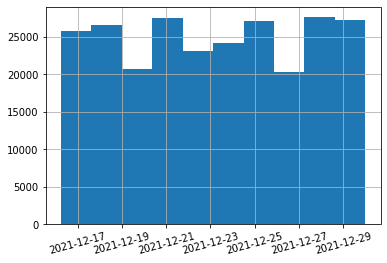

In [7]:
test_df.request_time.hist(xrot=15)

Преобразуем датасет в "тестовые" для дальнейшего анализа.

Получим сперва отклики нашего сервиса с лентой для каждого действия пользователя и затем проанализируем.

### Ответы сервиса с рекомендациями

In [8]:
# Класс модели нашей рекомендационной системы

class Model:
    """
    Класс Model для получения ленты новостей
    """
    def __init__(self):
        """
        Конструктор класса Model

        Загружает всё необходимое для обработки
        признаков и получения ленты.
        """
        self.control_model = CatBoostClassifier()
        self.test_model = CatBoostClassifier()

        self.control_model.load_model(CONFIG["classic_ml_model"])
        self.test_model.load_model(CONFIG["text_emb_model"])

        self.models_dict = {
            "control": self.control_model,
            "test": self.test_model
        }

        self.tables = {
            "posts": pd.read_csv(CONFIG["post_df"]),
            "users": pd.read_csv(CONFIG["user_df"]),
            "posts_tfidf": pd.read_csv(CONFIG["tfidf_df"]),
            "posts_lemmatized": pd.read_csv(CONFIG["lemmatized_post_df"]),
            "embs_post_df": pd.read_csv(CONFIG["embs_post_df"])
        }

    def get_feed(self, request: dict) -> FeedResponse:
        """
        Метод получения предсказания цены автомобиля.

        Производит обработку признаков запроса и
        получает рекомендованные новости.
        """
        exp_group = get_group(request["user_id"])
        posts_limit = request.get("posts_limit", 5)
        request = request_transform(request, exp_group, self.tables)

        request_model = self.models_dict[exp_group]
        col_order = request_model.feature_names_
        feed_prediction = request_model.predict_proba(request[col_order])[:, 1]

        indices = np.argpartition(
            feed_prediction,
            -posts_limit
        )[-posts_limit:]
        result_feed = self.tables["posts"].iloc[indices].reset_index()

        recs = []
        for i, post in result_feed.iterrows():
            recs.append(post["post_id"])
        return recs

In [9]:
# Напишем функцию получения рекомендаций по нашему датасету

def get_recs_row(row, model):
    return [post for post in model.get_feed(row)]


def get_recs_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция обработки датасета логов пользователей.
    
    По user_id и времени запроса добавляет к датасету
    колонки с группой пользователя и лентой, которую даёт наш сервис.
    """
    model = Model()
    df['exp_group'] = df.user_id.apply(lambda x: get_group(x))
    df['recommendations'] = df.apply(lambda x: get_recs_row(x, model), axis=1)
    return df


In [10]:
test_df = get_recs_df(test_df)

test_df.head()

,user_id,post_id,action,target,request_time,exp_group,recommendations
0,74168,3762,view,0,2021-12-23 11:15:02,control,"[466, 373, 2148, 482, 542]"
1,161011,1427,view,1,2021-12-24 17:30:11,test,"[6776, 7024, 6333, 4159, 4047]"
2,154745,5026,view,0,2021-12-26 17:24:23,control,"[1221, 1326, 1504, 1347, 1768]"
3,117989,3752,view,0,2021-12-27 21:20:12,control,"[4509, 6458, 6777, 5379, 4651]"
4,160820,5199,view,0,2021-12-20 13:14:13,test,"[2582, 2548, 3923, 3880, 3113]"


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          250000 non-null  int64         
 1   post_id          250000 non-null  int64         
 2   action           250000 non-null  object        
 3   target           250000 non-null  int64         
 4   request_time     250000 non-null  datetime64[ns]
 5   exp_group        250000 non-null  object        
 6   recommendations  250000 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.4+ MB


In [12]:
test_df.to_csv(CONFIG['datasets_folder'] + '/test_data_with_recs.csv', index=False)

### Проверим разбиение пользователей на группы

In [13]:
test_df = pd.read_csv(CONFIG['datasets_folder'] + '/test_data_with_recs.csv')

In [14]:
groups_num = test_df[['user_id', 'exp_group']].groupby('user_id').nunique()

groups_num[groups_num.exp_group == 2]

,exp_group
user_id,


Получили пустое множество - значит наш алгоритм разбиения пользователей на обозримом датасете не получил коллизий и не записал ни одного пользователя сразу в обе группы.

### Проверим равномерность разбиения

In [15]:
print(f"Всего пользователей в датасете: {test_df.user_id.nunique()}")
print(f"Пользователей в контрольной группе: {test_df[test_df.exp_group == 'control'].user_id.nunique()}")
print(f"Пользователей в экспериментальной группе: {test_df[test_df.exp_group == 'test'].user_id.nunique()}")

Всего пользователей в датасете: 108098
Пользователей в контрольной группе: 54152
Пользователей в экспериментальной группе: 53946


Разбиение получилось практически равным. На всякий случай убедимся, что разница статистически незначима.
Для этого проведем биномиальный тест и сравним доли.

Тогда примем:
1. Нулевая гипотеза - вероятность попадания пользователя в каждую группу симметрично
$$H0: p=0.5$$
2. Альтернативная гипотеза - алгоритм разбиения пользователей на группы несимметричен
$$H1: p\neq0.5$$
3. Уровень значимости
$$\alpha=0.05$$

In [16]:
# Посчитаем p-value полученного разбиения

groups_pvalue = binom_test(
    [
        test_df[test_df.exp_group == 'control'].user_id.nunique(),
        test_df[test_df.exp_group == 'test'].user_id.nunique()
    ]
)

print(f"p-value разбиения на группы: {groups_pvalue}")

p-value разбиения на группы: 0.5329481089055046


C:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Значение p-value больше уровня значимости, значит нулевую гипотезу отклонить не можем.

### Оценим количество лайков, поставленных за время эксперимента

In [17]:
# Посмотрим долю пользователей, которая сделала хотя бы один лайк за время наблюдения

likes_count = test_df[['user_id', 'target']].groupby('user_id').sum()

n_users = test_df.user_id.nunique()
n_users_w_like = likes_count[likes_count.target != 0].count().values[0]

print(f"Доля пользователей, поставившая хотя бы один лайк: {n_users_w_like / n_users}")

Доля пользователей, поставившая хотя бы один лайк: 0.24131806323891283


### Проверка целевой метрики

К сожалению, ввиду искусственности проводимого A\B-теста, ответить на вопрос "стали ли люди ставить больше лайков в экспериментальной группе" мы не сможем.
Потому оценим проведенную работу по созданию и улучшению рекомендационного сервиса с помощью метрики hitrate_5 - доле рекомендаций, где был поставлен хотя бы один лайк.

#### Сперва посмотрим на общий hitrate за время эксперимента

Опять же ввиду ограничений, метрику будем считать следующим образом:
1. Для всех действий пользователей посмотрим на то, есть ли просмотренный\лайкнутый пост в предложенных алгоритмом рекомендациях. В случае, если поста нет в ленте, предложенной нашим сервисом, не будем рассматривать данное действие при расчете метрики.
2. Посчитаем общий hitrate по всему эксперименту

In [18]:
# Раскроем рекомендации в столбцы
test_df['recommendations'] = test_df['recommendations'].astype(str)
recs = pd.DataFrame(test_df['recommendations'].str.strip(to_strip='[]').str.split(','))
recs_cols = lambda x: 'rec_{}'.format(x + 1)
recs_df = pd.DataFrame(recs.pop('recommendations').values.tolist()).rename(columns=recs_cols)
recs_df = recs_df.astype(int)
test_df = test_df.join(recs_df).drop(['recommendations'], axis=1)

test_df.head()

,user_id,post_id,action,target,request_time,exp_group,rec_1,rec_2,rec_3,rec_4,rec_5
0,74168,3762,view,0,2021-12-23 11:15:02,control,466,373,2148,482,542
1,161011,1427,view,1,2021-12-24 17:30:11,test,6776,7024,6333,4159,4047
2,154745,5026,view,0,2021-12-26 17:24:23,control,1221,1326,1504,1347,1768
3,117989,3752,view,0,2021-12-27 21:20:12,control,4509,6458,6777,5379,4651
4,160820,5199,view,0,2021-12-20 13:14:13,test,2582,2548,3923,3880,3113


In [19]:
# Теперь отфильтруем действия

hitrate_df = test_df[
    (test_df.post_id == test_df.rec_1) | (test_df.post_id == test_df.rec_2) | (test_df.post_id == test_df.rec_3) |
    (test_df.post_id == test_df.rec_4) | (test_df.post_id == test_df.rec_5)
]

hitrate_df

,user_id,post_id,action,target,request_time,exp_group,rec_1,rec_2,rec_3,rec_4,rec_5
1258,70873,1326,view,1,2021-12-16 07:23:04,control,1688,1326,1504,1768,1347
2881,19514,1221,like,0,2021-12-23 15:05:16,control,1221,1326,1504,1768,1347
3450,139792,3880,view,0,2021-12-27 15:22:05,test,2548,4144,3880,3113,3923
4403,60105,4651,like,0,2021-12-26 22:19:27,control,4651,4509,5379,6458,6777
5380,74935,2548,view,0,2021-12-20 07:16:28,test,2548,3880,3923,3113,1747
...,...,...,...,...,...,...,...,...,...,...,...
244807,121547,6776,view,0,2021-12-23 21:03:04,test,7024,6776,4047,4159,3915
245024,126777,4144,view,0,2021-12-27 12:36:28,test,2548,3923,3880,4144,3113
245149,125292,1347,view,0,2021-12-25 12:03:11,control,1221,1504,1768,1326,1347
247452,30334,1768,view,0,2021-12-23 12:16:34,control,1688,1326,1504,1347,1768


<AxesSubplot:>

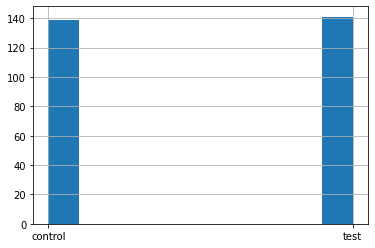

In [20]:
# Получили всего 280 совпадений. Для серьезной аналитики этого, конечно, 
# было бы недостаточно, но так как наш А\Б-тест несет синтетический характер - все же попробуем сравнить и оценить метрику.

hitrate_df.exp_group.hist()

In [21]:
# Заполним колонку target там, где view = like

hitrate_df.loc[hitrate_df.action == 'like', 'target'] = 1


Пользователь мог получить выдачу ленты и читать посты и, соответственно, лайкать их в разные моменты времени.
Мы же и выгружали не полные логи и формировали ленту для каждого действия пользователя.

Потому, хоть это и не совсем корректно, общий hitrate_5 будем считать как средний target.

In [22]:
overall_hitrate_5 = hitrate_df.target.mean()

print(f"Общий hitrate: {overall_hitrate_5}")

Общий hitrate: 0.33214285714285713


Полученное значение сильно ниже желаемых и полученных при проверке скрытым датасетом. Будем считать это последствием наших принятых допущений и ограничений при данном анализе.

### Сравним показатели метрики у разных групп пользователей

Ввиду того, что пользователи совершают множество действий, применить критерий для сравнения долей мы не можем - будем применять бакетный подход:
1. Разобъем датасет на подмножества бакетов
2. По каждому бакету оценим hitrate
3. Оценим полученные значения статистическим критерием и сделаем вывод о различии метрики между двумя группами

In [23]:
# Бакетирование. 
# Ввиду малого количества данных в hitrate_df будем использовать 10 бакетов

hitrate_df['bucket'] = hitrate_df['user_id'].apply(
    lambda x: int(md5((str(x) + 'bucket_salt').encode()).hexdigest(), 16) % 10
)

C:\Temp\ipykernel_736\3496021369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hitrate_df['bucket'] = hitrate_df['user_id'].apply(


In [24]:
# Оценки метрики внутри каждого бакета

test_hitrate_lst = []
control_hitrate_lst = []

for i in range(0, 10):
    bucket_df = hitrate_df[hitrate_df['bucket'] == i]
    
    control_bucket_df = bucket_df[bucket_df['exp_group'] == 'control']
    test_bucket_df = bucket_df[bucket_df['exp_group'] == 'test']
    
    bucket_hitrate_at_5_control = (control_bucket_df.target.mean())
    bucket_hitrate_at_5_test = (test_bucket_df.target.mean())
    
    control_hitrate_lst.append(bucket_hitrate_at_5_control)
    test_hitrate_lst.append(bucket_hitrate_at_5_test)

In [25]:
# Средние значения hitrate по группам

print(f"Среднее значение hitrate@5 в экспериментальной группе: {np.mean(test_hitrate_lst)}")
print(f"Среднее значение hitrate@5 в контрольной группе: {np.mean(control_hitrate_lst)}")

Среднее значение hitrate@5 в экспериментальной группе: 0.37156328320802007
Среднее значение hitrate@5 в контрольной группе: 0.34692513368983957


In [26]:
# Оценим статистическую значимость с помощью теста Манна-Уитни

ab_test_pvalue = mannwhitneyu(test_hitrate_lst, control_hitrate_lst)[1]
alpha = 0.05

print(f"P-value теста: {ab_test_pvalue}, при уровне значимости в {alpha}")

P-value теста: 1.0, при уровне значимости в 0.05


Что означает, что разница между полученными метриками статистически значима (p-value > alpha)

### Выводы

Таким образом, статистически значимая разница в целевой метрике hitrate@5 между экспериментальной и контрольной группой составляет ~2 процентных пункта. Это позволяет нам сделать главный вывод проделанной работы - в созданном нами сервисе рекомендации, получаемые экспериментальной моделью лучше контрольной. В случае реальных замеров можно было бы оценить прирост лайков, а так же посмотреть продуктовые метрики для более точной оценки полезности улучшений сервиса рекомендаций.